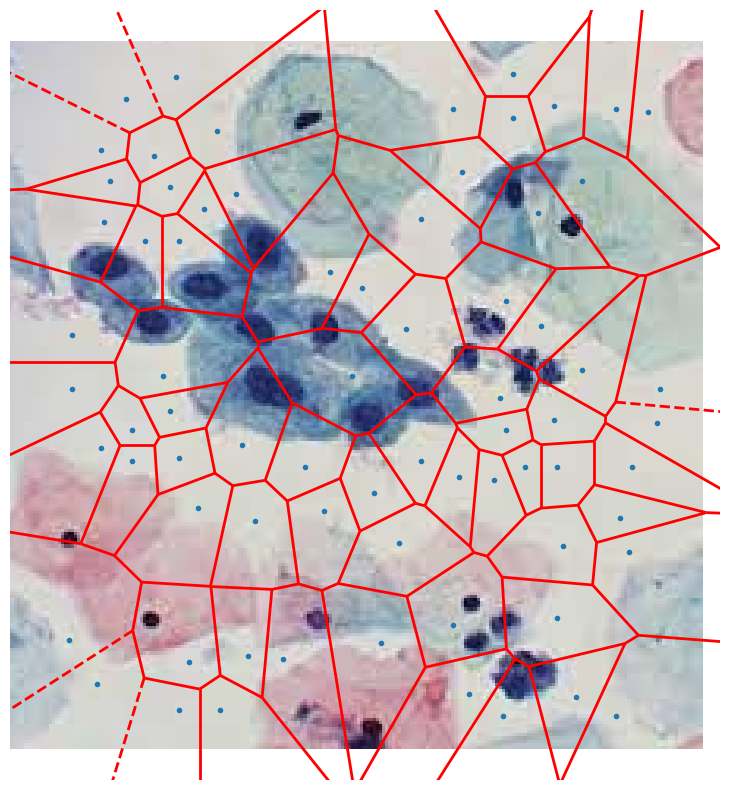

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



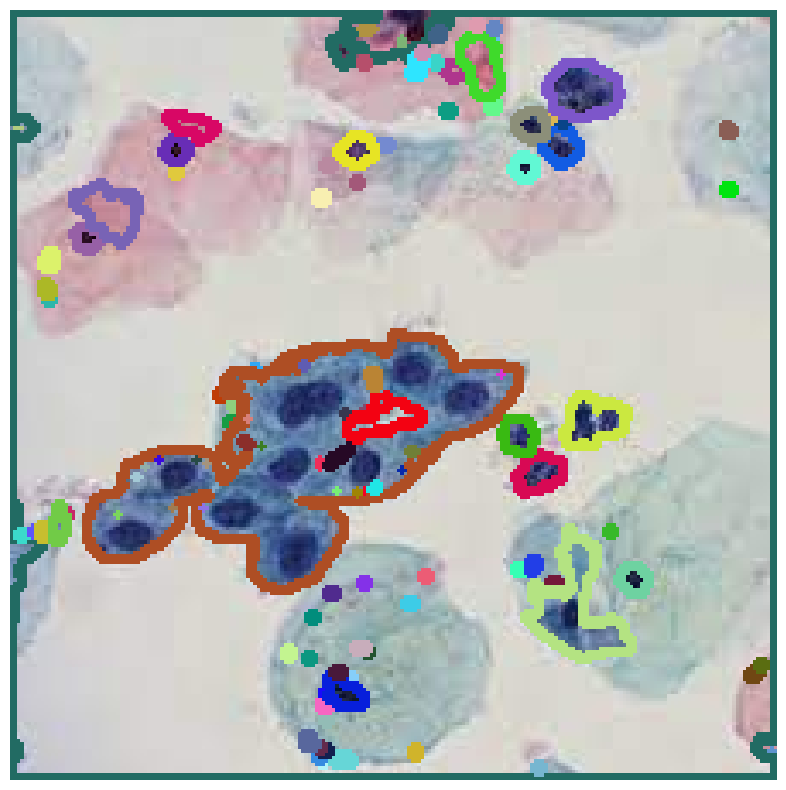

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from skimage.feature import peak_local_max
from sklearn.cluster import SpectralClustering
from PIL import Image, ImageFilter

class HybridImageSegmentation:
    def __init__(self, image_path, n_clusters=2, min_distance=10, threshold_abs=3, affinity='nearest_neighbors'):
        self.image_path = image_path
        self.n_clusters = n_clusters
        self.min_distance = min_distance
        self.threshold_abs = threshold_abs
        self.affinity = affinity
        self.image = cv2.imread(image_path)
        self.gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def preprocess_image(self):
        pil_image = Image.open(self.image_path).convert('L')
        pil_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
        image_array = np.array(pil_image)
        hsv_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        s = np.clip(cv2.multiply(s, 1.9), 0, 255)
        v = np.clip(cv2.multiply(v, 1.3), 0, 255)
        enhanced_hsv = cv2.merge([h, s, v])
        return cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR), image_array

    def find_local_maxima(self, image_array):
        coordinates = peak_local_max(image_array, min_distance=self.min_distance, threshold_abs=self.threshold_abs)
        return coordinates

    def overlay_voronoi_diagram(self, points):
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        points = points[:, ::-1]
        vor = Voronoi(points)
        voronoi_plot_2d(vor, show_vertices=False, line_colors='red', line_width=2, ax=plt.gca())
        plt.axis('off')
        plt.show()

    def spectral_clustering_segmentation(self, enhanced_image):
        gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        features = np.array([cv2.contourArea(contour) for contour in contours]).reshape(-1, 1)
        clustering = SpectralClustering(n_clusters=self.n_clusters, affinity=self.affinity, assign_labels='discretize').fit(features)
        return contours, clustering.labels_

    def visualize_clustering(self, contours, labels):
        plt.figure(figsize=(10, 10))
        for i, contour in enumerate(contours):
            color = [int(x) for x in np.random.choice(range(256), size=3)]
            cv2.drawContours(self.image, [contour], -1, color, 2)
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def run(self):
        enhanced_image, image_array = self.preprocess_image()
        local_maxima = self.find_local_maxima(image_array)
        self.overlay_voronoi_diagram(local_maxima)
        contours, labels = self.spectral_clustering_segmentation(enhanced_image)
        self.visualize_clustering(contours, labels)

# Usage example:
image_path = '/content/images.jpg' # Update with the correct path
segmenter = HybridImageSegmentation(image_path)
segmenter.run()

<ipython-input-9-c6dd9b5bc44c>:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



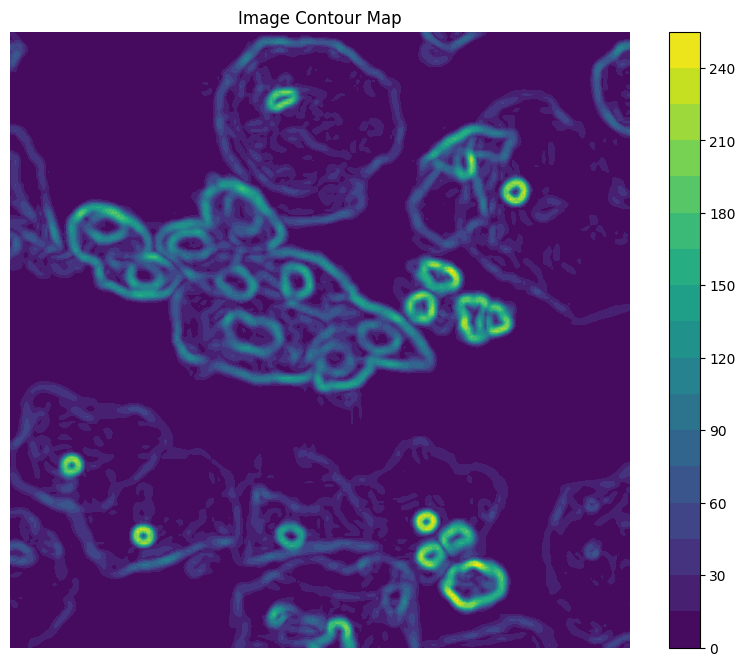

In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.color import rgb2gray

# Load the image
img_path = '/content/images.jpg'
img = imageio.imread(img_path)

# Convert image to grayscale
gray_img = rgb2gray(img)

# Apply Gaussian filter for smoothing (optional)
smoothed_img = gaussian_filter(gray_img, sigma=1)

# Define Scharr kernels
scharr_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]) / 32
scharr_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]) / 32

# Compute gradients
gradient_x = convolve(smoothed_img, scharr_x)
gradient_y = convolve(smoothed_img, scharr_y)

# Compute the magnitude of gradients
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# Normalize the gradient magnitude for better visualization
gradient_magnitude = np.interp(gradient_magnitude, (gradient_magnitude.min(), gradient_magnitude.max()), (0, 255))

# Define grid for plotting
x = np.linspace(0, img.shape[1]-1, img.shape[1])
y = np.linspace(0, img.shape[0]-1, img.shape[0])
X, Y = np.meshgrid(x, y)

# Plotting 3D surface
import plotly.graph_objects as go
fig_3d = go.Figure(data=[go.Surface(z=gradient_magnitude, x=X, y=Y, colorscale='Viridis')])
fig_3d.update_layout(title='3D Topographic Map of Image', autosize=True,
                     scene=dict(zaxis=dict(nticks=4, range=[0, 255]), camera=dict(eye=dict(x=2, y=-2, z=0.5))))
fig_3d.show()

# Plotting contour map
plt.figure(figsize=(10, 8))
contour_plot = plt.contourf(X, Y, gradient_magnitude, 20, cmap='viridis')
plt.colorbar(contour_plot)
plt.title('Image Contour Map')
plt.axis('off')
plt.show()


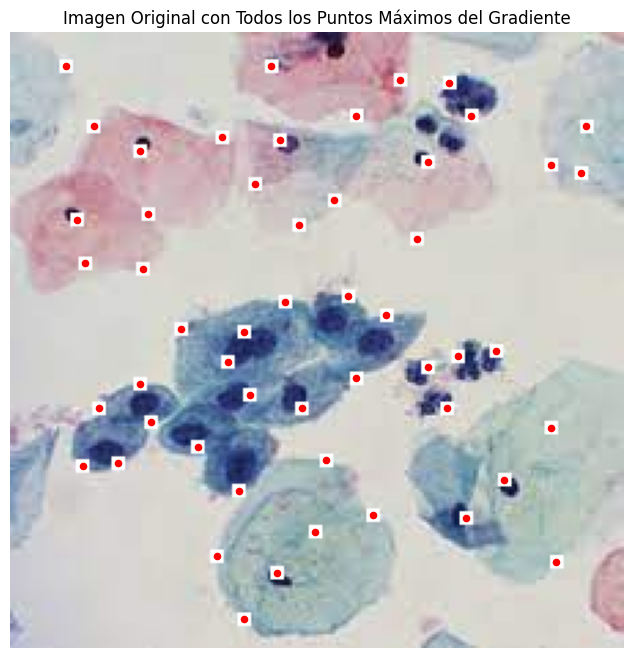

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.feature import peak_local_max

# Asumimos que img y gradient_magnitude ya están definidas y procesadas como se muestra en el código anterior.

# Paso 1: Encontrar todos los máximos locales
# Omitiendo explícitamente num_peaks
local_maxima = peak_local_max(gradient_magnitude, min_distance=10, threshold_abs=10)

# Paso 2: Marcar estos puntos en la imagen original
marked_img = img.copy()
for peak in local_maxima:
    y, x = peak
    marked_img[y-2:y+3, x-2:x+3] = 255  # Dibuja un pequeño cuadrado blanco alrededor del máximo

# Paso 3: Visualizar la imagen original con los puntos marcados
plt.figure(figsize=(10, 8))
plt.imshow(marked_img)
plt.scatter(local_maxima[:, 1], local_maxima[:, 0], c='red', s=20)  # Dibuja puntos rojos en los máximos
plt.axis('off')
plt.title('Imagen Original con Todos los Puntos Máximos del Gradiente')
plt.show()


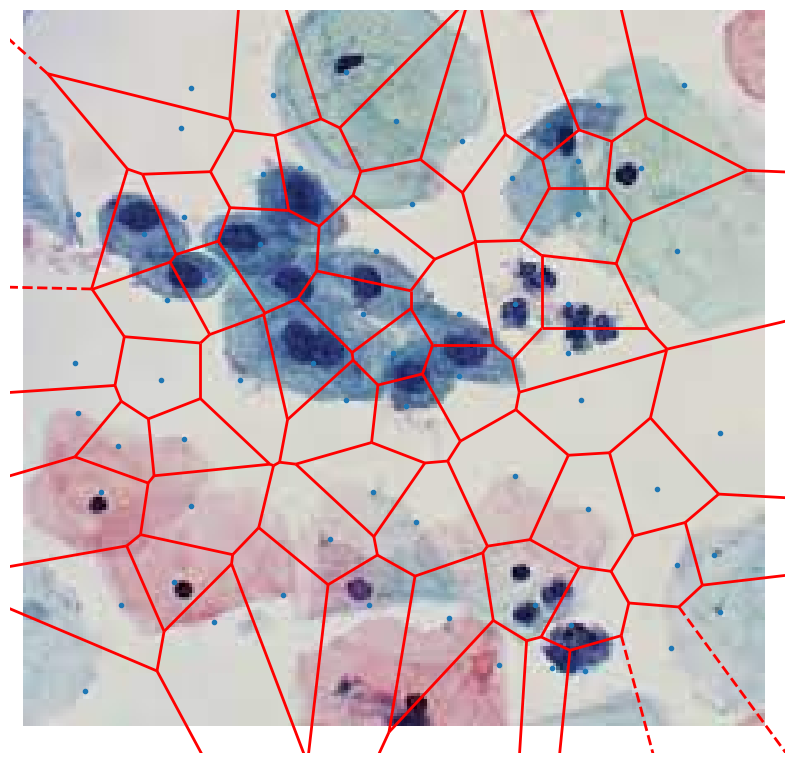

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



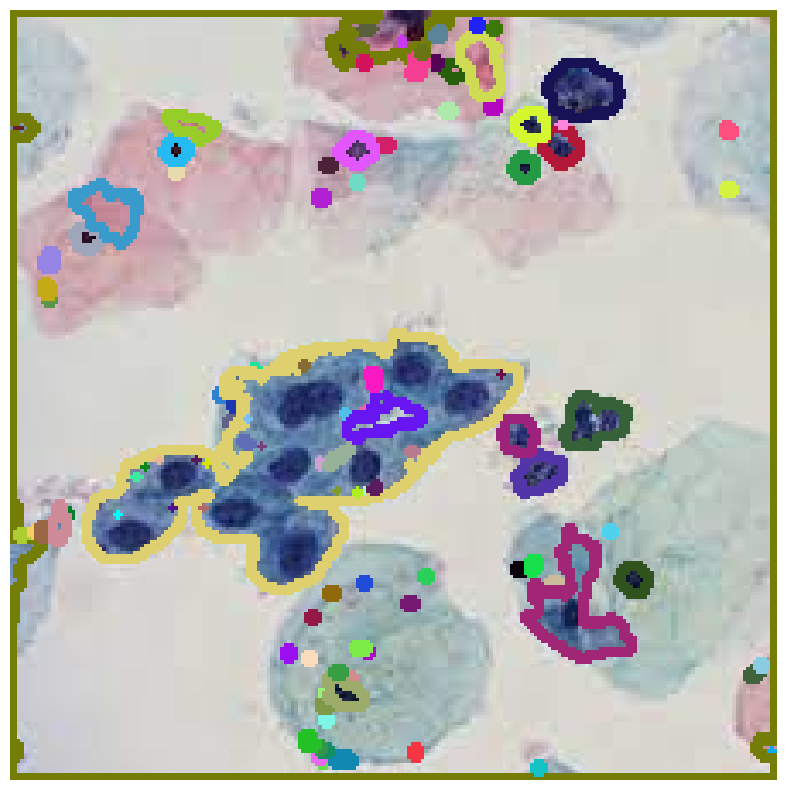

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from scipy.spatial import Voronoi, voronoi_plot_2d
from skimage.feature import peak_local_max
from skimage.color import rgb2lab
from sklearn.cluster import SpectralClustering, KMeans
from PIL import Image, ImageFilter

class HybridImageSegmentation:
    def __init__(self, image_path, n_clusters=3, min_distance=10, threshold_abs=3, affinity='nearest_neighbors'):
        self.image_path = image_path
        self.n_clusters = n_clusters
        self.min_distance = min_distance
        self.threshold_abs = threshold_abs
        self.affinity = affinity
        self.image = cv2.imread(image_path)
        self.gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.smoothed_img = gaussian_filter(self.gray_image, sigma=1)
        scharr_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]) / 32
        scharr_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]) / 32
        self.gradient_x = convolve(self.smoothed_img, scharr_x)
        self.gradient_y = convolve(self.smoothed_img, scharr_y)
        self.gradient_magnitude = np.sqrt(self.gradient_x**2 + self.gradient_y**2)
        self.gradient_magnitude = np.interp(self.gradient_magnitude, (self.gradient_magnitude.min(), self.gradient_magnitude.max()), (0, 255))

    def preprocess_image(self):
        pil_image = Image.open(self.image_path).convert('L')
        pil_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
        image_array = np.array(pil_image)
        hsv_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        s = np.clip(cv2.multiply(s, 1.9), 0, 255)
        v = np.clip(cv2.multiply(v, 1.3), 0, 255)
        enhanced_hsv = cv2.merge([h, s, v])
        return cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR), self.gradient_magnitude

    def find_local_maxima(self, image_array):
        coordinates = peak_local_max(image_array, min_distance=self.min_distance, threshold_abs=self.threshold_abs)
        return coordinates

    def overlay_voronoi_diagram(self, points):
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        points = points[:, ::-1]  # Reverse to match image coordinates
        vor = Voronoi(points)
        voronoi_plot_2d(vor, show_vertices=False, line_colors='red', line_width=2, ax=plt.gca())
        plt.axis('off')
        plt.show()

    def color_segmentation(self):
        lab_image = rgb2lab(self.image)
        lab_image_reshaped = lab_image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(lab_image_reshaped)
        segmented_image = kmeans.cluster_centers_[labels].reshape(lab_image.shape)
        return segmented_image.astype('uint8')

    def spectral_clustering_segmentation(self, enhanced_image):
        gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        features = np.array([cv2.contourArea(contour) for contour in contours]).reshape(-1, 1)
        clustering = SpectralClustering(n_clusters=self.n_clusters, affinity=self.affinity, assign_labels='discretize').fit(features)
        return contours, clustering.labels_

    def visualize_clustering(self, contours, labels):
        plt.figure(figsize=(10, 10))
        for i, contour in enumerate(contours):
            color = [int(x) for x in np.random.choice(range(256), size=3)]
            cv2.drawContours(self.image, [contour], -1, color, 2)
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def run(self):
        enhanced_image, image_array = self.preprocess_image()
        local_maxima = self.find_local_maxima(image_array)
        self.overlay_voronoi_diagram(local_maxima)
        contours, labels = self.spectral_clustering_segmentation(enhanced_image)
        self.visualize_clustering(contours, labels)

# Usage example:
image_path = '/content/images.jpg'  # Update with the correct path
segmenter = HybridImageSegmentation(image_path)
segmenter.run()

<ipython-input-13-de7779af6c2e>:35: FutureWarning:

indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.



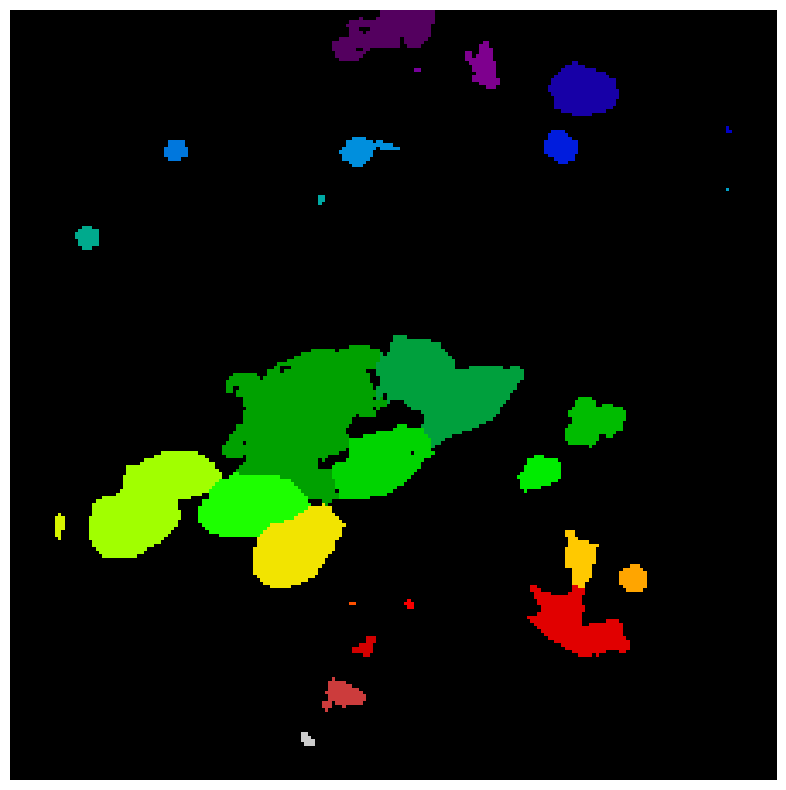

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve, distance_transform_edt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.color import rgb2lab
from sklearn.cluster import KMeans
from PIL import Image, ImageFilter

class HybridImageSegmentation:
    def __init__(self, image_path, n_clusters=10, min_distance=10, threshold_abs=3):
        self.image_path = image_path
        self.n_clusters = n_clusters
        self.min_distance = min_distance
        self.threshold_abs = threshold_abs
        self.image = cv2.imread(image_path)
        self.gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.smoothed_img = gaussian_filter(self.gray_image, sigma=1)
        self.preprocessed_image = self.preprocess_image()

    def preprocess_image(self):
        # Convert image to grayscale and blur it
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        # Perform Otsu thresholding
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return binary

    def apply_watershed(self):
        # Distance transform
        dist_transform = distance_transform_edt(self.preprocessed_image)
        # Find local maxima
        local_max = peak_local_max(dist_transform, min_distance=self.min_distance,
                                   labels=self.preprocessed_image, indices=False)
        # Perform connected component analysis
        markers = label(local_max)
        # Apply watershed
        labels = watershed(-dist_transform, markers, mask=self.preprocessed_image)
        return labels

    def run(self):
        watershed_labels = self.apply_watershed()
        plt.figure(figsize=(10, 10))
        plt.imshow(watershed_labels, cmap='nipy_spectral')
        plt.axis('off')
        plt.show()

# Usage example:
image_path = '/content/images.jpg'  # Update with the correct path
segmenter = HybridImageSegmentation(image_path)
segmenter.run()

